# Test

In [2]:
import torch

In [3]:
import torch.nn as nn

In [4]:
torch.cuda.is_available()

True

In [5]:
x = torch.rand(5, 3)
print(x)

tensor([[0.7209, 0.9404, 0.5645],
        [0.3859, 0.4065, 0.2243],
        [0.7746, 0.4664, 0.1597],
        [0.1633, 0.9118, 0.7845],
        [0.3802, 0.6604, 0.3582]])


# Start

In [1]:
import numpy as np
import pandas as pd

In [2]:


import torch
from torch import nn
# from torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [3]:
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
RS = 42

In [6]:
train = pd.read_pickle('clean-train-5.pkl')
test = pd.read_pickle('clean-test-5.pkl')

In [7]:
target = 'flag'
features = train.drop(columns=target).columns.tolist()

In [8]:
for col in train.columns:
    if train[col].dtype == bool:
        train[col] = train[col].astype(np.int8)
        test[col] = test[col].astype(np.int8)

In [9]:
X = train[features]
y = train[target]

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]



In [11]:
# Инициализируем тренировочный torch.dataset
train_dataset = MyDataset(X.values, y.values)

# Преобразуем тестовую выборку в torch-тензоры всю целиком
X_test_tensor = torch.from_numpy(test[features].values.astype(np.float32))
y_test_tensor = torch.from_numpy(test[target].values.astype(np.float32))

In [15]:
batch_size = 200

# Создайте Dataloader для тренировочной выборки на основе экземпляра train_dataset
# Делайте как в видео, размер батча – batch_size
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [16]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.hidden1 = nn.Linear(in_features=input_dim, out_features=hidden_dims[0], bias=True)
        self.f1 = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_dims[0])
        
        self.hidden2 = nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1], bias=True)
        self.f2 = nn.ReLU()
        
        # self.batchnorm2 = nn.BatchNorm1d(hidden_dims[1])
        
        self.hidden3 = nn.Linear(in_features=hidden_dims[1], out_features=hidden_dims[2], bias=True)
        self.f3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=1)
        
        self.output = nn.Linear(in_features=hidden_dims[2], out_features=output_dim, bias=True)
        
    def forward(self, X):
        X = self.f1(self.hidden1(X))
        
        # X = self.batchnorm(X)
        # X = self.dropout(X)
        
        X = self.f2(self.hidden2(X))
        # X = self.batchnorm2(X)
        
        X = self.f3(self.hidden3(X))
        X = self.output(X)
        X = self.sigmoid(X)
        # X = self.softmax(X)
        return X

torch.manual_seed(RS)

# Объявляем экземпляр класса нейронной сети
model = RegressionNet(411, (411, 12, 6), 1)

model.to(device)  # ++++++++++++++++++++++++++++++++++++++++

# Должен напечатать следующее:
#
# RegressionNet(
#   (hidden1): Linear(in_features=8, out_features=24, bias=True)
#   (f1): ReLU()
#   (hidden2): Linear(in_features=24, out_features=12, bias=True)
#   (f2): ReLU()
#   (hidden3): Linear(in_features=12, out_features=6, bias=True)
#   (f3): ReLU()
#   (output): Linear(in_features=6, out_features=1, bias=True)
# )
#
print(model)

RegressionNet(
  (hidden1): Linear(in_features=411, out_features=411, bias=True)
  (f1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm): BatchNorm1d(411, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2): Linear(in_features=411, out_features=12, bias=True)
  (f2): ReLU()
  (hidden3): Linear(in_features=12, out_features=6, bias=True)
  (f3): ReLU()
  (sigmoid): Sigmoid()
  (output): Linear(in_features=6, out_features=1, bias=True)
)


In [17]:
%%time
# Создайте объект класса, который реализует среднеквадратичную ошибку (MSE).
# loss_fn = nn.MSELoss()  # ВАШ КОД ЗДЕСЬ
loss_fn = nn.BCELoss()
# loss_fn = nn.CrossEntropyLoss()

X_test_gpu = X_test_tensor.to(device)


# Создаём оптимизатор. Тут будем использовать вариацию стохастического 
# градиентного спуска Adam. Это адаптивный алгоритм, который выбирает
# шаг изменения весов (learning rate) в зависимости от текущей ситуации. 
# Это очень эффективный алгоритм, который в большинстве случаев работает 
# лучше, чем обычный градиентный спуск с постоянным шагом. В этой задаче – 
# точно лучше. Если хотите убедиться, замените Adam на torch.optim.SDG
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Делаем 100 эпох
num_epochs = 10

# Сюда будем сохранять значение функции потерь на тестовой выборке
# после каждой эпохи обучения
loss_test = []
loss_train = []

# Реализуйте тренировочный цикл
for i in range(num_epochs):  # ВАШ КОД ЗДЕСЬ
    for X, y in train_dataloader:  # ВАШ КОД ЗДЕСЬ

    # Реализуйте все шаги тренировочного цикла PyTorch
    #
    # ВАШ КОД ЗДЕСЬ
    #
        X_g = X.to(device)
        y_g = y.to(device)
        
        pred = model(X_g)
        loss = loss_fn(pred, y_g.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_tr = loss_fn(pred, y_g.unsqueeze(-1))
    loss_train.append(loss_tr.item())

    with torch.no_grad():
        pred = model(X_test_gpu).to('cpu').detach().numpy()
        rocauc = roc_auc_score(test[target], pred)
        loss_test.append(rocauc)
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
#         loss = loss_fn(
#             model(X_test_tensor),
#             y_test_tensor.unsqueeze(-1)
#         ).item()
#         loss_test.append(loss)
    print(f'epoch {i} loss_train {loss_tr}    rocauc {rocauc}')

epoch 0 loss_train 0.09852542728185654    rocauc 0.7525375453496241
epoch 1 loss_train 0.09896870702505112    rocauc 0.7578759265914918
epoch 2 loss_train 0.15473532676696777    rocauc 0.7591959520880971
epoch 3 loss_train 0.19849887490272522    rocauc 0.7602724820394284
epoch 4 loss_train 0.15640613436698914    rocauc 0.7616308907118239
epoch 5 loss_train 0.08709590882062912    rocauc 0.7613870660537999
epoch 6 loss_train 0.1165982186794281    rocauc 0.7605847434084356
epoch 7 loss_train 0.1833702176809311    rocauc 0.7597703671664352
epoch 8 loss_train 0.16251744329929352    rocauc 0.7593558791493179
epoch 9 loss_train 0.09117133915424347    rocauc 0.7564337574075118
CPU times: total: 14min 17s
Wall time: 14min 1s


In [28]:
# Дообучение
for i in range(num_epochs):  # ВАШ КОД ЗДЕСЬ
    for X, y in train_dataloader:  # ВАШ КОД ЗДЕСЬ

    # Реализуйте все шаги тренировочного цикла PyTorch
    #
    # ВАШ КОД ЗДЕСЬ
    #
        X_g = X.to(device)
        y_g = y.to(device)
        
        pred = model(X_g)
        loss = loss_fn(pred, y_g.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_tr = loss_fn(pred, y_g.unsqueeze(-1))
    loss_train.append(loss_tr.item())

    with torch.no_grad():
        pred = model(X_test_gpu).to('cpu').detach().numpy()
        rocauc = roc_auc_score(test[target], pred)
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
#         loss = loss_fn(
#             model(X_test_tensor),
#             y_test_tensor.unsqueeze(-1)
#         ).item()
#         loss_test.append(loss)
    print(f'epoch {i} loss_train {loss_tr}    rocauc {rocauc}')

epoch 0 loss_train 0.139598548412323    rocauc 0.7347405704234224
epoch 1 loss_train 0.14240841567516327    rocauc 0.7371303518774304
epoch 2 loss_train 0.1302129626274109    rocauc 0.7381833096466305
epoch 3 loss_train 0.13290223479270935    rocauc 0.7406819385860204
epoch 4 loss_train 0.1422562152147293    rocauc 0.74048390600069
epoch 5 loss_train 0.1415494978427887    rocauc 0.74226846205861
epoch 6 loss_train 0.13240188360214233    rocauc 0.7422218594875989
epoch 7 loss_train 0.13692660629749298    rocauc 0.7434756967774446
epoch 8 loss_train 0.1358546018600464    rocauc 0.7435731993787332
epoch 9 loss_train 0.14681376516819    rocauc 0.7457567993248148


In [29]:
# Дообучение
for i in range(30):  # ВАШ КОД ЗДЕСЬ
    for X, y in train_dataloader:  # ВАШ КОД ЗДЕСЬ

    # Реализуйте все шаги тренировочного цикла PyTorch
    #
    # ВАШ КОД ЗДЕСЬ
    #
        X_g = X.to(device)
        y_g = y.to(device)
        
        pred = model(X_g)
        loss = loss_fn(pred, y_g.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_tr = loss_fn(pred, y_g.unsqueeze(-1))
    loss_train.append(loss_tr.item())

    with torch.no_grad():
        pred = model(X_test_gpu).to('cpu').detach().numpy()
        rocauc = roc_auc_score(test[target], pred)
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
#         loss = loss_fn(
#             model(X_test_tensor),
#             y_test_tensor.unsqueeze(-1)
#         ).item()
#         loss_test.append(loss)
    print(f'epoch {i} loss_train {loss_tr}    rocauc {rocauc}')

epoch 0 loss_train 0.13617216050624847    rocauc 0.7459803832060079
epoch 1 loss_train 0.1432255655527115    rocauc 0.7450552715085272
epoch 2 loss_train 0.12980107963085175    rocauc 0.7469279809197503
epoch 3 loss_train 0.13661377131938934    rocauc 0.7470309522652732
epoch 4 loss_train 0.13791076838970184    rocauc 0.7470900427585756
epoch 5 loss_train 0.14174149930477142    rocauc 0.7468127751513656
epoch 6 loss_train 0.13691213726997375    rocauc 0.747287434199946
epoch 7 loss_train 0.1382875144481659    rocauc 0.7482137291773514
epoch 8 loss_train 0.1392667293548584    rocauc 0.749108094409934
epoch 9 loss_train 0.13881823420524597    rocauc 0.7475037263560225
epoch 10 loss_train 0.1468576192855835    rocauc 0.7500075910849628
epoch 11 loss_train 0.1429845243692398    rocauc 0.7493948827839907
epoch 12 loss_train 0.13971205055713654    rocauc 0.7486521569092862
epoch 13 loss_train 0.13620367646217346    rocauc 0.7488540371159531
epoch 14 loss_train 0.1422923058271408    rocauc 0.

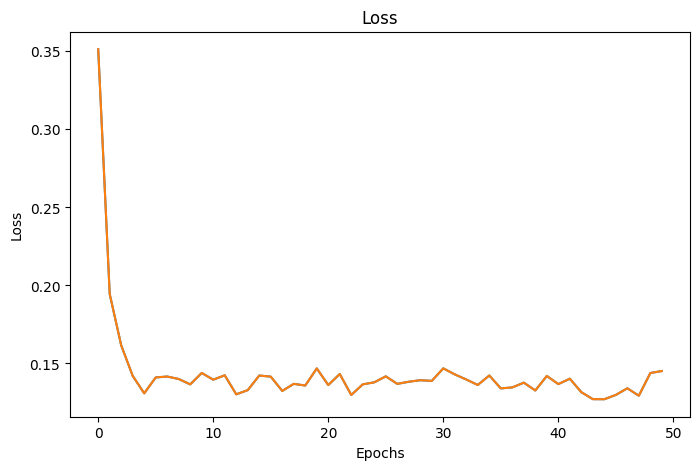

In [30]:
cnt = len(loss_train)
# step = np.arange(0, num_epochs)
step = np.arange(0, cnt)

fig, ax = plt.subplots(figsize=(8,5))

# Рисуем зависимость ошибки от эпохи обучения
plt.plot(step, np.array(loss_train))
plt.plot(step, np.array(loss_train))

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
with torch.no_grad():
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
        loss = loss_fn(
            model(X_test_tensor),
            y_test_tensor.unsqueeze(-1)
        ).item()
        loss_test.append(loss)
        print(f'epoch {i} loss_train {loss_tr}    loss {loss}')

In [72]:
pred = model(X_test_tensor.to(device)).to('cpu').detach().numpy()

In [73]:
roc_auc_score(test[target], pred)

0.6507655996022356

In [31]:
torch.cuda.empty_cache()

In [77]:
pred.max()

1.0

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
#     def input_size(self):
#         return self.X.shape[1]

In [38]:
class CreditNN(nn.Module):
    def __init__(self, input_size=411, hidden_1_size=1000, out_size=1):
        super(CreditNN, self).__init__()
        self.to(device)
        self.input_size = input_size
        self.dense1 = nn.Linear(self.input_size, hidden_1_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(hidden_1_size, out_size)
#         self.normalize = nn.BatchNorm1d(hidden_1_size)
#         self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.to(device)
    
    def forward(self, x):
        x = self.dense1(x)
        x = self.relu(x)
#         x = x.view(-1, self.dense1.out_features)
#         x = self.normalize(x)
#         x = self.dropout(x)
        x = self.dense2(x)
#         x = self.sigmoid(x)
#         x = self.softmax(x)
        return x
    
    def fit(self, data_loader, optimizer, criterion, epochs=10, verbose=True):
        self.__init__(input_size=data_loader.dataset.X.shape[1])
        print(self.input_size)
        for epoch in range(epochs):
            for x_batch, y_batch in data_loader:
                y_batch = y_batch.to(device)
                y_pred = self(x_batch.to(device))
                loss = criterion(y_batch, y_pred[:, 0])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if verbose: 
                print(f'Epoch #{epoch}: \tloss: {loss.item():.5f}')
                print(y_batch)
                print(y_pred[:, 0])
#                 print(loss.item())
        print(f'Training loss: {loss.item():.4f}')
        
    def predict(self, X):
        return self(torch.from_numpy(X.astype(np.float32)).to(device))

In [39]:
my_nn = CreditNN()

In [40]:
loss_fn = nn.MSELoss()
# loss_fn = nn.BCELoss()
# loss_fn = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.000001)

In [41]:
my_nn.to(device)

CreditNN(
  (dense1): Linear(in_features=411, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1000, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [19]:
y.values.shape

(2100000,)

In [20]:
train_data = MyDataset(X.values, y.values)

In [28]:
batch_size = 3_000

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

In [22]:
train_dataloader.dataset.X.shape

torch.Size([2100000, 411])

In [42]:
%%time
my_nn.fit(train_dataloader, optimizer, loss_fn)

411
Epoch #0: 	loss: 116.39467
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([11.0980, 12.0988,  9.7547,  ..., 12.1003,  9.9975, 11.6913],
       device='cuda:0', grad_fn=<SelectBackward0>)
Epoch #1: 	loss: 116.26477
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([ 7.8907,  6.5455, 12.4232,  ..., 10.0564, 10.8875,  7.9546],
       device='cuda:0', grad_fn=<SelectBackward0>)
Epoch #2: 	loss: 117.20963
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([ 6.2683,  9.9263, 12.1005,  ...,  9.3983,  9.4393, 12.3862],
       device='cuda:0', grad_fn=<SelectBackward0>)
Epoch #3: 	loss: 117.73159
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([ 7.5290, 11.6397, 12.5696,  ..., 10.8295, 17.5697,  9.8097],
       device='cuda:0', grad_fn=<SelectBackward0>)
Epoch #4: 	loss: 117.52104
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([12.2983,  8.1309,  8.5450,  ...,  9.9426, 10.8708, 10.7213],
       device='cuda:0', grad_fn=

In [43]:
lss_pred = my_nn(torch.from_numpy(test[features].values.astype(np.float32)).to(device))


In [44]:
pred = lss_pred.to('cpu').detach().numpy()

In [45]:
roc_auc_score(test[target], pred)

0.5356464384658775

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
import torch.nn as nn

class MyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        self.f1 = nn.ReLU()
        
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.f2 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.f1(self.hidden(x))
        x = self.f2(self.output(x))
        
        return x

In [ ]:
my_net = MyNet(2, 16, 1)

print(my_net)

In [ ]:
y_pred = my_net(torch.from_numpy(X_test.astype(np.float32)))

In [ ]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(my_net.parameters(), lr=0.1)

In [ ]:
num_epochs = 50

loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        
        pred = my_net(X)
        
        loss = loss_fn(pred, y.unsqueeze(-1))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    loss = loss_fn(pred, y.unsqueeze(-1))
    loss_values.append(loss.item())

In [ ]:
step = np.linspace(0, num_epochs)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [80]:
%%time
# Создайте объект класса, который реализует среднеквадратичную ошибку (MSE).
# loss_fn = nn.MSELoss()  # ВАШ КОД ЗДЕСЬ
# loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()

X_test_gpu = X_test_tensor.to(device)


# Создаём оптимизатор. Тут будем использовать вариацию стохастического 
# градиентного спуска Adam. Это адаптивный алгоритм, который выбирает
# шаг изменения весов (learning rate) в зависимости от текущей ситуации. 
# Это очень эффективный алгоритм, который в большинстве случаев работает 
# лучше, чем обычный градиентный спуск с постоянным шагом. В этой задаче – 
# точно лучше. Если хотите убедиться, замените Adam на torch.optim.SDG
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Делаем 100 эпох
num_epochs = 10

# Сюда будем сохранять значение функции потерь на тестовой выборке
# после каждой эпохи обучения
loss_test = []
loss_train = []

# Реализуйте тренировочный цикл
for i in range(num_epochs):  # ВАШ КОД ЗДЕСЬ
    for X, y in train_dataloader:  # ВАШ КОД ЗДЕСЬ

    # Реализуйте все шаги тренировочного цикла PyTorch
    #
    # ВАШ КОД ЗДЕСЬ
    #
        X_g = X.to(device)
        y_g = y.to(device)
        
        pred = model(X_g)
        loss = loss_fn(pred, y_g.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_tr = loss_fn(pred, y_g.unsqueeze(-1))
    loss_train.append(loss_tr.item())

    with torch.no_grad():
        pred = model(X_test_gpu).to('cpu').detach().numpy()
        rocauc = roc_auc_score(test[target], pred)
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
#         loss = loss_fn(
#             model(X_test_tensor),
#             y_test_tensor.unsqueeze(-1)
#         ).item()
#         loss_test.append(loss)
    print(f'epoch {i} loss_train {loss_tr}    rocauc {rocauc}')

epoch 0 loss_train 0.59307461977005    rocauc 0.5631392618904505
epoch 1 loss_train 0.3998393416404724    rocauc 0.5920715957311883
epoch 2 loss_train 0.2785755395889282    rocauc 0.6711860498985128
epoch 3 loss_train 0.19279980659484863    rocauc 0.6903045202897271
epoch 4 loss_train 0.15606869757175446    rocauc 0.7113603221724513
epoch 5 loss_train 0.1487884670495987    rocauc 0.720374700532411
epoch 6 loss_train 0.1459091454744339    rocauc 0.7303886727048639
epoch 7 loss_train 0.14826242625713348    rocauc 0.7301517125891628
epoch 8 loss_train 0.13726936280727386    rocauc 0.7422040803103565
epoch 9 loss_train 0.14441458880901337    rocauc 0.7448896232498196
CPU times: total: 11min 44s
Wall time: 11min 25s


In [16]:
%%time
# Создайте объект класса, который реализует среднеквадратичную ошибку (MSE).
# loss_fn = nn.MSELoss()  # ВАШ КОД ЗДЕСЬ
# loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.KLDivLoss()

X_test_gpu = X_test_tensor.to(device)


# Создаём оптимизатор. Тут будем использовать вариацию стохастического 
# градиентного спуска Adam. Это адаптивный алгоритм, который выбирает
# шаг изменения весов (learning rate) в зависимости от текущей ситуации. 
# Это очень эффективный алгоритм, который в большинстве случаев работает 
# лучше, чем обычный градиентный спуск с постоянным шагом. В этой задаче – 
# точно лучше. Если хотите убедиться, замените Adam на torch.optim.SDG
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Делаем 100 эпох
num_epochs = 10

# Сюда будем сохранять значение функции потерь на тестовой выборке
# после каждой эпохи обучения
loss_test = []
loss_train = []

# Реализуйте тренировочный цикл
for i in range(num_epochs):  # ВАШ КОД ЗДЕСЬ
    for X, y in train_dataloader:  # ВАШ КОД ЗДЕСЬ

    # Реализуйте все шаги тренировочного цикла PyTorch
    #
    # ВАШ КОД ЗДЕСЬ
    #
        X_g = X.to(device)
        y_g = y.to(device)
        
        pred = model(X_g)
        loss = loss_fn(y_g.unsqueeze(-1), pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_tr = loss_fn(y_g.unsqueeze(-1), pred)
    loss_train.append(loss_tr.item())

    with torch.no_grad():
        pred = model(X_test_gpu).to('cpu').detach().numpy()
        rocauc = roc_auc_score(test[target], pred)
        loss_test.append(rocauc)
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
#         loss = loss_fn(
#             model(X_test_tensor),
#             y_test_tensor.unsqueeze(-1)
#         ).item()
#         loss_test.append(loss)
    print(f'epoch {i} loss_train {loss_tr}    rocauc {rocauc}')

epoch 0 loss_train -0.37944909930229187    rocauc 0.6827021592018724


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 1 loss_train -0.38222846388816833    rocauc 0.7164108036940022


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 2 loss_train -0.3840351998806    rocauc 0.7286779110992091


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 3 loss_train -0.37969309091567993    rocauc 0.7301265090027421


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 4 loss_train -0.3792288601398468    rocauc 0.735871961987474


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 5 loss_train -0.38075873255729675    rocauc 0.7385811564200825


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 6 loss_train -0.38166189193725586    rocauc 0.7361765148562248


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 7 loss_train -0.3820490539073944    rocauc 0.7439058370946375


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 8 loss_train -0.38144537806510925    rocauc 0.7420210612260202


C:\Users\Lenovo\.conda\envs\tf-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch 9 loss_train -0.3821074068546295    rocauc 0.7411221680506287
CPU times: total: 11min 47s
Wall time: 11min 28s


In [14]:
%%time
# Создайте объект класса, который реализует среднеквадратичную ошибку (MSE).
# loss_fn = nn.MSELoss()  # ВАШ КОД ЗДЕСЬ
loss_fn = nn.BCELoss()
# loss_fn = nn.CrossEntropyLoss()

X_test_gpu = X_test_tensor.to(device)


# Создаём оптимизатор. Тут будем использовать вариацию стохастического 
# градиентного спуска Adam. Это адаптивный алгоритм, который выбирает
# шаг изменения весов (learning rate) в зависимости от текущей ситуации. 
# Это очень эффективный алгоритм, который в большинстве случаев работает 
# лучше, чем обычный градиентный спуск с постоянным шагом. В этой задаче – 
# точно лучше. Если хотите убедиться, замените Adam на torch.optim.SDG
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Делаем 100 эпох
num_epochs = 50

# Сюда будем сохранять значение функции потерь на тестовой выборке
# после каждой эпохи обучения
loss_test = []
loss_train = []

# Реализуйте тренировочный цикл
for i in range(num_epochs):  # ВАШ КОД ЗДЕСЬ
    for X, y in train_dataloader:  # ВАШ КОД ЗДЕСЬ

    # Реализуйте все шаги тренировочного цикла PyTorch
    #
    # ВАШ КОД ЗДЕСЬ
    #
        X_g = X.to(device)
        y_g = y.to(device)
        
        pred = model(X_g)
        loss = loss_fn(pred, y_g.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_tr = loss_fn(pred, y_g.unsqueeze(-1))
    loss_train.append(loss_tr.item())

    with torch.no_grad():
        pred = model(X_test_gpu).to('cpu').detach().numpy()
        rocauc = roc_auc_score(test[target], pred)
        loss_test.append(rocauc)
    # Конец эпохи: считаем функцию потерь на тестовой выборке, 
    # сохраняем в список, чтобы потом нарисовать график
#         loss = loss_fn(
#             model(X_test_tensor),
#             y_test_tensor.unsqueeze(-1)
#         ).item()
#         loss_test.append(loss)
    print(f'epoch {i} loss_train {loss_tr}    rocauc {rocauc}')

epoch 0 loss_train 0.08613904565572739    rocauc 0.751999714997233
epoch 1 loss_train 0.13183069229125977    rocauc 0.7566377822041987
epoch 2 loss_train 0.1615244299173355    rocauc 0.7597330150879396
epoch 3 loss_train 0.1339513063430786    rocauc 0.760743667691282
epoch 4 loss_train 0.1613963395357132    rocauc 0.7618317727937988
epoch 5 loss_train 0.11829637736082077    rocauc 0.7617187928023512
epoch 6 loss_train 0.16194510459899902    rocauc 0.7617747471466019
epoch 7 loss_train 0.1757342666387558    rocauc 0.7588868788342622
epoch 8 loss_train 0.13757367432117462    rocauc 0.7594788017693348
epoch 9 loss_train 0.13235490024089813    rocauc 0.7573768005730903
epoch 10 loss_train 0.13063859939575195    rocauc 0.7583590725498827
epoch 11 loss_train 0.11811397224664688    rocauc 0.7562705914915506
epoch 12 loss_train 0.14084723591804504    rocauc 0.7534233498087161
epoch 13 loss_train 0.11459673196077347    rocauc 0.7512250569426394
epoch 14 loss_train 0.13819751143455505    rocauc 